<a href="https://colab.research.google.com/github/Sbarbagnem/AdvancedProject/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module
**caricare prima librerie di smac e poi il resto**

In [1]:
#!pip uninstall scikit-learn -y
#!pip install scikit-learn==0.21.3
!apt-get install swig
!pip install smac
!pip install smac[all]
!pip install smt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


In [3]:
import cv2
import os
import numpy as np
import pandas as pd
from math import ceil
import xml.etree.ElementTree as ET
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")
import gc

from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50, MobileNet
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from keras.applications.mobilenet import preprocess_input as preprocess_input_mobilenet
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Activation
from keras import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras import backend as K

from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [0]:
from smac.configspace import ConfigurationSpace 
from smac.configspace import UniformFloatHyperparameter, UniformIntegerHyperparameter, CategoricalHyperparameter, InCondition
from smac.configspace import Configuration # serve per costruire le configurazioni iniziali da passare alla funzione di minimizzazione
from smac.scenario.scenario import Scenario
from smac.facade.smac_bo_facade import SMAC4BO # bayesian optimization with GaussianProcess
from smac.facade.smac_hpo_facade import SMAC4HPO # bayesian optimization with RandomForest
from smac.optimizer.acquisition import EI, LCB, PI
from smac.runhistory.runhistory import RunHistory # util class to collect all data of optimization
from smac.initial_design.latin_hypercube_design import LHDesign
from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.stats.stats import Stats # util class to save history on directory
from smac.utils.io.traj_logging import TrajLogger
#from smac.optimizer.objective import average_cost

# Costant

In [4]:
drive.mount('/content/drive')

PATH_ANNOTATIONS = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Annotations/'
PATH_MAIN = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Main/'
PATH_IMAGES = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Images/'
PATH_IMAGES_CROPPED_TRAIN = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Cropped_train/'
PATH_IMAGES_CROPPED_VAL_TEST = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Cropped_val_test/'
PATH_IMAGES_CROPPED_TRAIN_BALANCED = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Cropped_train_balanced/'
PATH_IMAGES_CROPPED_VAL_TEST_BALANCED = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Cropped_val_test_balanced/'
PATH_OPTIMIZATION = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Ottimizzazione/'
PATH_PICKLE = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Pickles/'

BATCH_SIZE = 64
IM_SIZE = (128, 128)

LABELS = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
          'car', 'cat', 'chair', 'cow', 'diningtable',
          'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
          'train', 'tvmonitor']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Directory for cropped images

In [0]:
# creo 20 directory, una per ogni classe, per fare classificazione (flow_from_datframe) sulle immagini croppate
def create_directories(path, labels):
  for label in labels:
    os.mkdir(os.path.join(path, label))

create_folder_classes = True
'''
if create_folder_classes == True:
  create_directories(PATH_IMAGES_CROPPED_TRAIN, LABELS)
  create_directories(PATH_IMAGES_CROPPED_VAL_TEST, LABELS)
'''
if create_folder_classes == True:
  #create_directories(PATH_IMAGES_CROPPED_TRAIN_BALANCED, LABELS)
  create_directories(PATH_IMAGES_CROPPED_VAL_TEST_BALANCED, LABELS)

# Util function for mapping from label to #class

In [0]:
def create_dict_mapping(labels):
  mapping = {}
  for label,i in zip(labels, range(len(labels))):
    mapping[label] = i
  return mapping

def from_label_to_number(mapping, label):
  return mapping[label]

def from_number_to_label(mapping, number):
  for key, val in mapping.items(): 
    if val == number: 
      return key 
  return "key doesn't exist"

def from_onehot_to_label(mapping, one_hot):
  return from_number_to_label(mapping,np.where(one_hot == 1)[0][0])

In [0]:
mapping = create_dict_mapping(LABELS)
print(mapping)

{'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


# Crop and save image for class

In [0]:
def crop_image(img, x_min, y_min, x_max, y_max):
  crop_img = img[y_min:y_max, x_min:x_max]
  if (y_max-y_min) >= 100 and (x_max-x_min) >= 100:
    crop_img = cv2.resize(crop_img, IM_SIZE)
    return crop_img
  else:
    return None

In [0]:
def list_images(path_images, path_txt, file_txt):
  # creo liste immagini presenti in file_txt
  temp = []
  f = open(os.path.join(path_txt, file_txt), "r")
  for line in f.readlines():
    temp.append(line.split('\n')[0] + '.jpg')
  list_images = [os.path.join(path_images, name) for name in temp]
  print('Ho trovato ', len(list_images), 'per il file ', file_txt)
  return list_images

# creo liste immagini da train.txt e val.txt
list_images_train = list_images(PATH_IMAGES, PATH_MAIN, 'train.txt')
list_images_val = list_images(PATH_IMAGES, PATH_MAIN, 'val.txt')

In [0]:
train_count = {}

# dict to count number of image for every class
for label in LABELS:
  train_count[label] = 0

In [0]:
def read_and_crop(list_images, annotation_dir, path_to_save, train=False):
  '''
  leggo annotations dei file presenti nelle due liste di immagini 
  '''
  for path in list_images:
    image_name = path.split('/')[-1].split('.')[0] 
    print(image_name)
    with open(os.path.join(annotation_dir, image_name + '.xml')) as f:
      read_xml(f.read(), path, path_to_save, train)
  return

def read_xml(file_xml, path_image, path_to_save, train=False):
  '''
  leggo xml e per ogni box che trovo croppo e salvo
  '''
  #print(path_image)
  img = cv2.imread(path_image)  
  root = ET.XML(file_xml)
  for _, child in enumerate(root):
    if child.tag == 'object':
      x_min = None
      y_min = None
      x_max = None
      y_max = None
      for subchild in child:
        if subchild.tag == 'name':
          name_object = subchild.text
          #print(name_object)
        if subchild.tag == 'bndbox':
          for bndbox in subchild:
            if bndbox.tag == 'xmin':
              x_min = int(bndbox.text)
              #print('x_min ', x_min)
            if bndbox.tag == 'ymin':
              y_min = int(bndbox.text)
              #print('y_min ', y_min)
            if bndbox.tag == 'xmax':
              x_max = int(bndbox.text)
              #print('x_max ', x_max)
            if bndbox.tag == 'ymax':
              y_max = int(bndbox.text)
              #print('y_max ', y_max)
        if(x_min!=None and y_min!=None and x_max!=None and y_max!=None):
          if(train_count[name_object] < 500 and train) or (not train):
            image_cropped = crop_image(img, x_min, y_min, x_max, y_max)
            x_min = None
            y_min = None
            x_max = None
            y_max = None
            #cv2_imshow(image_cropped)
            if image_cropped is not None:
              save_image_cropped(name_object, image_cropped, path_to_save, train)
  return 

def save_image_cropped(obj, img, path_to_save, train=False):
  '''
  salvo immagine croppata con numero progressivo in base 
  all'ultima presente nella cartella
  '''
  list_dir_classes = os.listdir(path_to_save)
  for dir_class in list_dir_classes:
    if dir_class == obj:
      dir_temp = os.path.join(path_to_save,dir_class)
      list_temp = os.listdir(dir_temp)
      if list_temp == []:
        cv2.imwrite(os.path.join(dir_temp, obj + '_1.jpg'), img)
        if train:
          train_count[obj] += 1
      else:
        number_file = int(list_temp[-1].split('.')[0].split('_')[1]) + 1
        cv2.imwrite(os.path.join(dir_temp, obj + '_' + str(number_file) + '.jpg'), img)
        if train:
          train_count[obj] += 1
  return

#read_and_crop(list_images=list_images_train, annotation_dir=PATH_ANNOTATIONS, path_to_save=PATH_IMAGES_CROPPED_TRAIN_BALANCED, train=True)
read_and_crop(list_images=list_images_val, annotation_dir=PATH_ANNOTATIONS, path_to_save=PATH_IMAGES_CROPPED_VAL_TEST_BALANCED, train=False)

In [0]:
train_count


# Generator from directory

In [0]:
def create_generator( batch_size, im_size, train_directory, val_directory, labels,
                      validation_split, aug, augment_params):
    
  preprocess_function = preprocess_input_vgg16

  if not(aug):
    img_gen_train = ImageDataGenerator(#rescale=1./255, 
                                       preprocessing_function=preprocess_function)
  elif aug:
    img_gen_train = ImageDataGenerator( preprocessing_function=preprocess_function,
                                        #rescale=1./255,
                                        **augment_params)  


  img_gen_val = ImageDataGenerator( preprocessing_function=preprocess_function,
                                    validation_split = validation_split
                                  )
    
  train_gen = img_gen_train.flow_from_directory(
      directory = train_directory,
      shuffle=True,
      class_mode='categorical',
      target_size=im_size,
      batch_size=batch_size,
      classes=labels,
      seed=42
  )

  val_gen = img_gen_val.flow_from_directory(
      directory = val_directory,
      shuffle=False,
      class_mode='categorical',
      target_size=im_size,
      batch_size=batch_size,
      subset='training',
      classes=labels,
      seed=42
  )

  test_gen = img_gen_val.flow_from_directory(
      directory = val_directory,
      shuffle=False,
      class_mode='categorical',
      target_size=im_size,
      batch_size=batch_size,
      subset='validation',
      classes=labels,
      seed=42
  )

  return train_gen, val_gen, test_gen

# Generator from image in memory

In [0]:
def create_generator_for_pickle( images_train, labels_train, images_val, labels_val, batch_size, base_net,
                      validation_split, aug, augment_params):
  
  if base_net == 'vgg16':
    preprocess_function = preprocess_input_vgg16
  elif base_net == 'mobilenet':
    preprocess_function = preprocess_input_mobilenet
  elif base_net == 'resnet':
    preprocess_function = preprocess_input_resnet50

  if not(aug):
    img_gen_train = ImageDataGenerator(preprocessing_function=preprocess_function)
  elif aug:
    img_gen_train = ImageDataGenerator( preprocessing_function=preprocess_function,
                                        **augment_params)  


  img_gen_val = ImageDataGenerator( preprocessing_function=preprocess_function,
                                    validation_split = validation_split
                                  )
    
  train_gen = img_gen_train.flow(
      x = images_train,
      y = labels_train,
      shuffle=True,
      batch_size=batch_size,
      seed=42
  )

  val_gen = img_gen_val.flow(
      x = images_val,
      y = labels_val,
      shuffle=False,
      batch_size=batch_size,
      subset='training',
      seed=42
  )

  test_gen = img_gen_val.flow(
      x = images_val,
      y = labels_val,
      shuffle=False,
      batch_size=batch_size,
      subset='validation',
      seed=42
  )

  return train_gen, val_gen, test_gen

# Frequency classes

In [0]:
def get_frequency_from_generator(generator):
  mapping = generator.class_indices
  classes, count = np.unique(generator.labels, return_counts=True)
  labels = [from_number_to_label(mapping, label) for label in classes]
  freq = count
  return labels, freq

def normalize_frequency(freq):
  min_freq = np.min(freq)
  weigh = [min_freq/x for x in freq]
  return weigh * freq, weigh

def plot_label_frequency(labels, freq):
  freq = freq / np.sum(freq)
  l = list(range(1, len(labels)+1))
  plt.barh(l, width=freq, height=0.5)
  plt.yticks(l, labels, rotation='horizontal')
  plt.show()

def plot_stacked_bar_freq(labels, freq, freq_normalize):
  N = len(labels)
  ind = np.arange(N)    # the x locations for the groups
  width = 0.35       # the width of the bars: can also be len(x) sequence

  p1 = plt.bar(ind, freq, width)
  p2 = plt.bar(ind, freq_normalize, width)

  plt.ylabel('Frequency')
  plt.legend((p1[0], p2[0]), ('Freq', 'Freq_normalize'))

  plt.show() 

In [0]:
labels, freq = get_frequency_from_generator(train_gen)


In [0]:
print(labels)
print(freq)

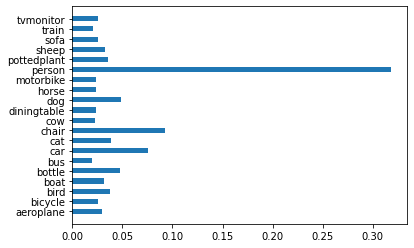

In [0]:
plot_label_frequency(labels, freq)

In [0]:
freq_normalize = normalize_frequency(freq)
print(freq_normalize)

(array([317., 317., 317., 317., 317., 317., 317., 317., 317., 317., 317.,
       317., 317., 317., 317., 317., 317., 317., 317., 317.]), [0.674468085106383, 0.7731707317073171, 0.535472972972973, 0.6240157480314961, 0.4232309746328438, 1.0, 0.2661628883291352, 0.5205254515599343, 0.2175703500343171, 0.8929577464788733, 0.8498659517426274, 0.4127604166666667, 0.8408488063660478, 0.8453333333333334, 0.06315999203028491, 0.5691202872531418, 0.6227897838899804, 0.7944862155388471, 0.9694189602446484, 0.7694174757281553])


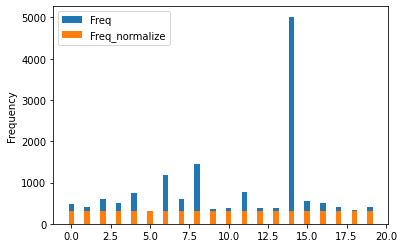

In [0]:
plot_stacked_bar_freq(labels, freq, freq_normalize[0])

# Model feature extractor

In [0]:
def feature_extraction(cut_layer, dense, dropouts, im_size, loss, optimizer, metrics, verbose=False):
  '''
    viene definito il layer di cut della vgg e vengono aggiunti una serie di layer densi prima dell'output
  '''
  print('porco ziooooooooooo')
  base_model = VGG16(weights = 'imagenet', input_shape=im_size + (3,), include_top = False)

  x = base_model.layers[cut_layer].output
  x = GlobalAveragePooling2D()(x)
  for layer,dropout in zip(dense,dropouts):
    x = Dense(layer, activation='relu')(x)
    x = Dropout(dropout)(x)
  predictions = Dense(20, activation = 'softmax')(x)
  model = Model(input = base_model.input, output = predictions)

  for layer in base_model.layers:
    layer.trainable=False
    
  if verbose:
    model.summary()

  model.compile(loss=loss, 
                optimizer=optimizer, 
                metrics=metrics
  )
      
  return model

# Model fine tuning

In [0]:
def fine_tuning(freeze_to, dense, dropouts, im_size, loss, optimizer, metrics, verbose=False):
  '''
    vengono definiti i layer della vgg trainabili e i dense layer prima dell'output
  '''
  
  base_model = VGG16(weights = 'imagenet', input_shape=im_size + (3,), include_top = False)

  x = base_model.layers[-1].output
  x = GlobalAveragePooling2D()(x) 

  for layer,dropout in zip(dense,dropouts): 
    x = Dense(layer, activation='relu')(x)
    x = Dropout(dropout)(x)
  predictions = Dense(20, activation = 'softmax')(x)
  model = Model(input = base_model.input, output = predictions)

  for layer in base_model.layers[:freeze_to]:
    layer.trainable=False
  for layer in model.layers[freeze_to:]: # layer su cui applicare fine tuning
    layer.trainable = True

  if verbose:
    model.summary()

  model.compile(loss=loss, 
                optimizer=optimizer, 
                metrics=metrics
  )
      
  return model

# Plot performance epoch

In [0]:
def plot_performance(history):
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

# Util to load train/val pickle

In [0]:
def load_pickle(path_file, one_hot=True):

  file = open(path_file, 'rb')
  data = pickle.load(file)
  file.close()
  images = data[0]
  labels = data[1]

  if one_hot:
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(labels.reshape(-1,1))
    labels_one_hot = enc.transform(labels.reshape(-1,1)).toarray()

  return images, labels_one_hot

# Experiments

## Set up generator

In [0]:
#base_net = 'vgg16'

augment_params = dict(  rotation_range=30,
                        horizontal_flip=True,
                        zoom_range=0.1
                      )

train_gen, val_gen, test_gen = create_generator(batch_size=BATCH_SIZE, 
                                                im_size=IM_SIZE, 
                                                train_directory=PATH_IMAGES_CROPPED_TRAIN_BALANCED, 
                                                val_directory=PATH_IMAGES_CROPPED_VAL_TEST_BALANCED, 
                                                labels=LABELS,
                                                validation_split=0.7,
                                                aug=True,
                                                augment_params=augment_params
                                                )



Found 5680 images belonging to 20 classes.
Found 2341 images belonging to 20 classes.
Found 5432 images belonging to 20 classes.


In [0]:
x,y = train_gen.next()
for i in range(0,10):
    image = x[i]
    plt.figure()
    plt.imshow(image)
    plt.title(from_onehot_to_label(mapping, y[i]))
    plt.show

train_gen.reset()

## Analyze frequency label in generator

In [0]:
labels, freq = get_frequency_from_generator(train_gen)
plot_label_frequency(labels, freq)
freq_normalize, weigh = normalize_frequency(freq)
#plot_label_frequency(labels, freq_normalize)
plot_stacked_bar_freq(labels, freq, freq_normalize)
'''
# dict for weigh model
weigh_class = {}
for label,i in zip(labels, weigh):
  weigh_class[from_label_to_number(mapping, label)] = i
'''

In [0]:
weigh_class

{0: 0.674468085106383,
 1: 0.7731707317073171,
 2: 0.535472972972973,
 3: 0.6240157480314961,
 4: 0.4232309746328438,
 5: 1.0,
 6: 0.2661628883291352,
 7: 0.5205254515599343,
 8: 0.2175703500343171,
 9: 0.8929577464788733,
 10: 0.8498659517426274,
 11: 0.4127604166666667,
 12: 0.8408488063660478,
 13: 0.8453333333333334,
 14: 0.06315999203028491,
 15: 0.5691202872531418,
 16: 0.6227897838899804,
 17: 0.7944862155388471,
 18: 0.9694189602446484,
 19: 0.7694174757281553}

## Set up iper-parameter for fit and model

In [0]:
loss = 'categorical_crossentropy'
optimizer = 'adam'
reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, 
                                      verbose=1, mode='auto', min_delta=0.0001, 
                                      cooldown=0, min_lr=0.000001)
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5, 
                           verbose=1,
                           restore_best_weights=True
                           )
model_checkpoint = ModelCheckpoint(filepath='best_weights.h5', 
                                   monitor='val_loss', 
                                   save_best_only=True)
metrics = ['categorical_accuracy']
epochs = 50
steps_per_epoch = ceil(train_gen.n / train_gen.batch_size)
validation_steps = ceil(val_gen.n / val_gen.batch_size)
test_steps = ceil(test_gen.n / test_gen.batch_size)
dense = []

## Create model

In [0]:
# model feauture extraction
model = feature_extraction(cut_layer=-1,
                           dense=[512, 256, 128, 64],
                           dropouts=[0.2,0.2,0.2,0.2],
                           im_size=IM_SIZE,
                           loss='categorical_crossentropy',
                           optimizer=optimizer,
                           metrics=metrics,
                           verbose=False
                           )
# TODO model fine tuning
'''
model = fine_tuning(freeze_to=15,
                    dense=[128, 64],
                    dropouts=[0.2,0.2],
                    im_size=IM_SIZE,
                    loss='categorical_crossentropy,
                    optimizer=optimizer,
                    metrics=metrics,
                    verbose=False)
'''
for index,layer in enumerate(model.layers):
  print(index, ' ', layer.name, ' ', layer.trainable)


## Fit prova

In [0]:
net_history = model.fit_generator(train_gen, epochs=2, verbose=1,
                                  validation_data = val_gen,
                                  steps_per_epoch = steps_per_epoch,
                                  validation_steps = validation_steps,
                                  callbacks = [early_stop, reduce_on_plateau]                 
                                  )

Epoch 1/2
89/89 [==============================] - 3891s 44s/step - loss: 2.7898 - categorical_accuracy: 0.2632 - val_loss: 0.6715 - val_categorical_accuracy: 0.6886
Epoch 2/2
89/89 [==============================] - 27s 300ms/step - loss: 1.5000 - categorical_accuracy: 0.5521 - val_loss: 0.2958 - val_categorical_accuracy: 0.7715


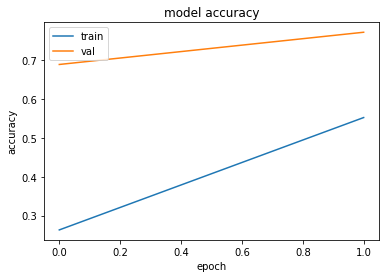

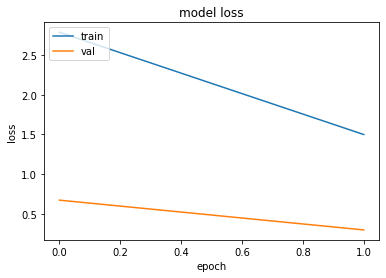

In [0]:
plot_performance(net_history)

In [0]:
loss, accuracy = model.evaluate(test_gen, steps=test_steps)

37/37 [==============================] - 4s 115ms/step


In [0]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.295815646648407
Accuracy: 0.7714651823043823


# AutoML

## Create dataframe for k-cross-fold optimization

In [0]:
def dataframe_path_class(path_images):
  df = pd.DataFrame(columns=['absolute_path', 'class'])
  list_dir = os.listdir(path_images)
  for sub_dir in list_dir:
    list_images = os.listdir(os.path.join(path_images, sub_dir))  
    for image in list_images:
      df = df.append({'absolute_path': os.path.join(path_images, sub_dir, image),
                      'class' : str(sub_dir)} , 
                     ignore_index=True)
  return df

df_train = dataframe_path_class(PATH_IMAGES_CROPPED_TRAIN_BALANCED)
df_val_test = dataframe_path_class(PATH_IMAGES_CROPPED_VAL_TEST_BALANCED)

# creo df_test che uso solo dopo ottimizzazione iperparametri
df_val, df_test = train_test_split(df_val_test, test_size=0.7)

# unisco df_val a df_train per avere un train generale su cui eseguire k-cross-fold validation
df_train = df_train.append(df_val, ignore_index=True)

# salvo i due dataframe
df_train.to_csv(PATH_OPTIMIZATION + 'train_k_cross.csv')
df_test.to_csv(PATH_OPTIMIZATION + 'test.csv')

print(df_train.shape, df_test.shape)

## k-cross-fold to optimize 

In [0]:
def cross_validation_optimization(cfg):

  kf = KFold(n_splits=2, random_state=None, shuffle=True) # 3 

  #accuracy_on_fold = []
  losses = []

  i = 1
  for train_index, val_index in kf.split(df_train):

    #gc.collect()
    K.clear_session()

    # creo modello sulla base delle configurazioni in cfg
    if cfg['number_layer'] == 1:
      dense = [cfg['number_first_layer']]
      dropouts = [cfg['dropout_first_layer']]
    elif cfg['number_layer'] == 2:
      dense = [cfg['number_first_layer'], 
               cfg['number_second_layer']]
      dropouts = [cfg['dropout_first_layer'],
                 cfg['dropout_second_layer']]
    elif cfg['number_layer'] == 3:
      dense = [cfg['number_first_layer'], 
               cfg['number_second_layer'], 
               cfg['number_third_layer']]
      dropouts = [cfg['dropout_first_layer'],
                 cfg['dropout_second_layer'],
                 cfg['dropout_third_layer']]
    elif cfg['number_layer'] == 4:
      dense = [cfg['number_first_layer'], 
               cfg['number_second_layer'], 
               cfg['number_third_layer'], 
               cfg['number_fourth_layer']]
      dropouts = [cfg['dropout_first_layer'],
                 cfg['dropout_second_layer'],
                 cfg['dropout_third_layer'],
                 cfg['dropout_third_layer']]

    if cfg['optimizier'] == 'SGD':
      optimizer = SGD(learning_rate=cfg['learning_rate'], momentum=cfg['momentum'])
      if cfg['nestorov'] == True:
        optimizer.nestorov = True
    elif cfg['optimizier'] == 'adam':
      optimizer = Adam(learning_rate=cfg['learning_rate'])

    print('create generator')
    trainGenerator = ImageDataGenerator(preprocessing_function=preprocess_input_vgg16,
                                        rotation_range=30,
                                        horizontal_flip=True,
                                        zoom_range=0.1
                                        )
    valGenerator = ImageDataGenerator(preprocessing_function=preprocess_input_vgg16)
    
    print('create train val and test')
    trainData = df_train.iloc[train_index,:]
    trainData, valData = train_test_split(trainData, test_size=0.2)
    testData = df_train.iloc[val_index,:]

    print("=========================================")
    print("====== K Fold Validation step => %d =======" % (i))
    print("=========================================")

    print('flow from train dataframe')
    train_gen = valGenerator.flow_from_dataframe(
      dataframe = trainData,
      x_col='absolute_path',
      y_col='class',
      shuffle=True,
      class_mode='categorical',
      target_size=IM_SIZE,
      batch_size=BATCH_SIZE,
      classes=LABELS,
    )

    print('flow from val dataframe')
    val_gen = valGenerator.flow_from_dataframe(
      dataframe = valData,
      x_col='absolute_path',
      y_col='class',
      shuffle=False,
      class_mode='categorical',
      target_size=IM_SIZE,
      batch_size=BATCH_SIZE,
      classes=LABELS,
    )

    print('flow from test dataframe')
    test_gen = valGenerator.flow_from_dataframe(
      dataframe = testData,
      x_col='absolute_path',
      y_col='class',
      shuffle=False,
      class_mode='categorical',
      target_size=IM_SIZE,
      batch_size=BATCH_SIZE,
      classes=LABELS,
    ) 
    
    step_train = ceil(train_gen.n/train_gen.batch_size)
    step_val = ceil(val_gen.n/val_gen.batch_size)
    step_test = ceil(test_gen.n/test_gen.batch_size)

    reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                          verbose=1, mode='auto', min_delta=0.0001, 
                                          cooldown=0, min_lr=0.00001)
    early_stop = EarlyStopping(monitor='val_loss', 
                              patience=5, 
                              verbose=1,
                              restore_best_weights=True
                              )

    if to_optimize == 'feature_extraction':
      print('feature extraction')
      model = feature_extraction(cut_layer=cfg['cut_layer'],
                                dense=dense,
                                dropouts=dropouts,
                                im_size=IM_SIZE,
                                loss='categorical_crossentropy',
                                optimizer=optimizer,
                                metrics=['categorical_accuracy'],
                                verbose=False
                                )
    if to_optimize == 'fine_tuning':
      model = fine_tunining(freeze_to=cfg['freeze_to'],
                                        dense=dense,
                                        dropouts=dropouts,
                                        im_size=IM_SIZE,
                                        loss='categorical_crossentropy',
                                        optimizer=optimizer,
                                        metrics=['categorical_accuracy'],
                                        verbose=False) 
    
    print("Inizio fit")
    
    history = model.fit_generator(generator=train_gen, 
                                  epochs=50, 
                                  verbose=1,
                                  validation_data = val_gen,
                                  steps_per_epoch = step_train,
                                  validation_steps = step_val,
                                  callbacks = [early_stop, reduce_on_plateau],
                                  )

    # test on testData
    print("Predict on test")
    '''
    predictions = model.predict_generator(test_gen, 
                                          steps=step_test,
                                          )
    
    accuracy_on_fold.append(accuracy_score(y_true=test_gen.labels, 
                                          y_pred=np.argmax(predictions, axis=1)
                                          )
                          )
    '''
    # evaluate test and return loss
    loss, _ = model.evaluate_generator(test_gen, steps=step_test)
    losses.append(loss)
    i+=1

  return np.mean(losses) # minimizzo loss media sulla 3-cross validation
  #return 1 - np.mean(accuracy_on_fold)

## Configuration space

In [0]:
def create_configuration_space(to_optimize):

  cs = ConfigurationSpace()

  # iper-parametri da ottimizzare
  '''
    Optimizier: categorical ('adam', 'SGD')
    Learning_rate: uniform_float [0.01, 0.00001]
    Momentum: categorical and condition (True,False) if 'SGD'
    Nestorov: uniform_float and condition [0.9, 0.8] if 'SGD'
    Dropout: uniform_float [0.2,0.4]
    Number_fully_connected: categorical (1,2)
    Number_neurons_first_layer: uniform_integer [64, 1024]
    Numebr_neurons_second_layer: uniform_integer and condition [64,1024] if number_fully_connected==2
  '''
  optimizier_param = CategoricalHyperparameter(name='optimizier',
                                              choices=['adam', 'SGD'],
                                              default_value='SGD')

  lr_param = UniformFloatHyperparameter(name="learning_rate", 
                                        lower=0.000001, 
                                        upper=0.001, 
                                        default_value=0.001)
  momentum_param = UniformFloatHyperparameter(name='momentum',
                                              lower=0.1,
                                              upper=0.9,
                                              default_value=0.5
                                              )
  cond_momentum = InCondition(child=momentum_param, 
                              parent=optimizier_param, 
                              values=['SGD'])

  nestorov_param = CategoricalHyperparameter(name="nestorov", 
                                            choices=[True, False], 
                                            default_value=False)
  cond_nestorov = InCondition(child=nestorov_param, 
                              parent=optimizier_param, 
                              values=['SGD'])
  
  number_layer_param = UniformIntegerHyperparameter(name='number_layer',
                                          lower=1,
                                          upper=4,
                                          default_value=2)
  
  dropout_first_layer = UniformFloatHyperparameter(name='dropout_first_layer',
                                            lower=0.2,
                                            upper=0.4,
                                            default_value=0.2)
  dropout_second_layer = UniformFloatHyperparameter(name='dropout_second_layer',
                                            lower=0.2,
                                            upper=0.4,
                                            default_value=0.2)
  dropout_third_layer = UniformFloatHyperparameter(name='dropout_third_layer',
                                            lower=0.2,
                                            upper=0.4,
                                            default_value=0.2)
  dropout_fourth_layer = UniformFloatHyperparameter(name='dropout_fourth_layer',
                                            lower=0.2,
                                            upper=0.4,
                                            default_value=0.2)

  neurons_first_layer_param = UniformIntegerHyperparameter(name='number_first_layer',
                                                    lower=64,
                                                    upper=1024,
                                                    default_value=512)

  neurons_second_layer_param = UniformIntegerHyperparameter(name='number_second_layer',
                                                    lower=64,
                                                    upper=1024,
                                                    default_value=512)
  neurons_third_layer_param = UniformIntegerHyperparameter(name='number_third_layer',
                                                  lower=64,
                                                  upper=1024,
                                                  default_value=512)

  neurons_fourth_layer_param = UniformIntegerHyperparameter(name='number_fourth_layer',
                                                    lower=64,
                                                    upper=1024,
                                                    default_value=512)
  cond_first_layer = InCondition(child=neurons_first_layer_param,
                                parent=number_layer_param,
                                values=[1,2,3,4])
  cond_second_layer = InCondition(child=neurons_second_layer_param,
                                  parent=number_layer_param,
                                  values=[2,3,4])
  cond_third_layer = InCondition(child=neurons_third_layer_param,
                                  parent=number_layer_param,
                                  values=[3,4])
  cond_fourth_layer = InCondition(child=neurons_fourth_layer_param,
                                  parent=number_layer_param,
                                  values=[4])
  
  cond__dropout_first_layer = InCondition(child=dropout_first_layer,
                                parent=number_layer_param,
                                values=[1,2,3,4])
  cond_dropout_second_layer = InCondition(child=dropout_second_layer,
                                  parent=number_layer_param,
                                  values=[2,3,4])
  cond_dropout_third_layer = InCondition(child=dropout_third_layer,
                                  parent=number_layer_param,
                                  values=[3,4])
  cond_dropout_fourth_layer = InCondition(child=dropout_fourth_layer,
                                  parent=number_layer_param,
                                  values=[4])
  
  if to_optimize == 'feature_extraction':
    cut_layer = CategoricalHyperparameter(name='cut_layer',
                                          choices=[6,10,14,18],
                                          default_value=14)
    cs.add_hyperparameters([cut_layer])
  if to_optimize == 'fine_tuning':
    freeze_to = UniformIntegerHyperparameter(name='freeze_to',
                                             lower=7,
                                             upper=19,
                                             default_value=15)
    cs.add_hyperparameters([freeze_to])
  cs.add_hyperparameters([optimizier_param, 
                          lr_param,
                          momentum_param,
                          nestorov_param,
                          number_layer_param,
                          neurons_first_layer_param,
                          neurons_second_layer_param,
                          neurons_third_layer_param,
                          neurons_fourth_layer_param,
                          dropout_first_layer,
                          dropout_second_layer,
                          dropout_third_layer,
                          dropout_fourth_layer
                          ])
  cs.add_conditions([cond_momentum,
                    cond_nestorov,
                    cond_first_layer,
                    cond_second_layer,
                    cond_third_layer,
                    cond_fourth_layer,
                    cond__dropout_first_layer,
                    cond_dropout_second_layer,
                    cond_dropout_third_layer,
                    cond_dropout_fourth_layer
                    ])

  return cs

## Scenario

In [8]:
to_optimize = 'feature_extraction'
#to_optimize = 'fine_tuning'

cs = create_configuration_space(to_optimize)
scenario = Scenario({"run_obj": "quality",  
                     "runcount-limit": 20, # 15 + 5 configurazioni iniziali   
                     "cs": cs,               
                     "deterministic": "true"
                     })
# All statistics collected during configuration run. Written to output-directory to be restored
stat = Stats(scenario=scenario)


traj_logger  = TrajLogger(output_dir=PATH_OPTIMIZATION + 'traj_logger/',
                          stats=stat)

run_history = RunHistory()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2020-06-15_00:15:54_664342


## Optimization

In [0]:
rng = np.random.RandomState(seed=42)

df_train = pd.read_csv(PATH_OPTIMIZATION + 'train_k_cross.csv')

smac = SMAC4HPO(scenario=scenario,
                rng=rng,
                runhistory=run_history,
                tae_runner=cross_validation_optimization,
                initial_design=RandomConfigurations, # LHDesign
                initial_design_kwargs={'n_configs_x_params': 5},
                acquisition_function=EI
                )

incumbent = smac.optimize()

# save optim value and history confinguration tried
if to_optimize == 'feature_extraction':
  with open(PATH_OPTIMIZATION + 'incubent_feature_extraction.pkl', 'wb') as f:  
      pickle.dump(incumbent, f)
  with open(PATH_OPTIMIZATION + 'history_feature_extraction.pkl', 'wb') as f:  
      pickle.dump(run_history, f)
if to_optimize == 'fine_tuning':
  with open(PATH_OPTIMIZATION + 'incumbent_fine_tuning.pkl', 'wb') as f:  
      pickle.dump(incumbent, f)
  with open(PATH_OPTIMIZATION + 'history_fine_tuning.pkl', 'wb') as f:  
      pickle.dump(run_history, f)

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
ERROR:smac.utils.io.output_writer.OutputWriter:Could not write pcs file to disk. ConfigSpace not compatible with (new) pcs format.
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 2 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


create generator
create train val and test
====== K Fold Validation step => 1 =======
flow from train dataframe
Found 3204 validated image filenames belonging to 20 classes.
flow from val dataframe
Found 801 validated image filenames belonging to 20 classes.
flow from test dataframe
Found 4006 validated image filenames belonging to 20 classes.
feature extraction
porco ziooooooooooo
Inizio fit
Epoch 1/50
51/51 [==============================] - 8s 160ms/step - loss: 13.4007 - categorical_accuracy: 0.1239 - val_loss: 2.9951 - val_categorical_accuracy: 0.1261
Epoch 2/50
51/51 [==============================] - 6s 113ms/step - loss: 3.0892 - categorical_accuracy: 0.1439 - val_loss: 2.9944 - val_categorical_accuracy: 0.1261
Epoch 3/50
51/51 [==============================] - 6s 119ms/step - loss: 3.0409 - categorical_accuracy: 0.1442 - val_loss: 2.9937 - val_categorical_accuracy: 0.1261
Epoch 4/50
51/51 [==============================] - 6s 118ms/step - loss: 3.0255 - categorical_accuracy: 

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 2.9396
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 2.9396


create generator
create train val and test
====== K Fold Validation step => 1 =======
flow from train dataframe
Found 3204 validated image filenames belonging to 20 classes.
flow from val dataframe
Found 801 validated image filenames belonging to 20 classes.
flow from test dataframe
Found 4006 validated image filenames belonging to 20 classes.
feature extraction
porco ziooooooooooo
Inizio fit
Epoch 1/50
51/51 [==============================] - 8s 157ms/step - loss: 5.0086 - categorical_accuracy: 0.1458 - val_loss: 1.7368 - val_categorical_accuracy: 0.4956
Epoch 2/50
51/51 [==============================] - 6s 108ms/step - loss: 2.9030 - categorical_accuracy: 0.2787 - val_loss: 1.5743 - val_categorical_accuracy: 0.5880
Epoch 3/50
51/51 [==============================] - 6s 118ms/step - loss: 2.3476 - categorical_accuracy: 0.3530 - val_loss: 1.4005 - val_categorical_accuracy: 0.6067
Epoch 4/50
51/51 [==============================] - 6s 120ms/step - loss: 2.1213 - categorical_accuracy: 0

INFO:smac.intensification.intensification.Intensifier:Challenger (1.2671) is better than incumbent (2.9396) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  cut_layer : 14 -> 18
INFO:smac.intensification.intensification.Intensifier:  dropout_first_layer : 0.27018626697982884 -> 0.3479008468380841
INFO:smac.intensification.intensification.Intensifier:  dropout_second_layer : 0.3099927883619568 -> 0.22536676367917013
INFO:smac.intensification.intensification.Intensifier:  dropout_third_layer : None -> 0.3264191256300771
INFO:smac.intensification.intensification.Intensifier:  learning_rate : 0.0007279980174341478 -> 0.0009329351308489859
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.16231298330980526 -> 0.6334631176114999
INFO:smac.intensification.intensification.Intensifier:  nestorov : False -> True
INFO:smac.intensification.intensification.Intensifier:  number_first_laye

create generator
create train val and test
====== K Fold Validation step => 1 =======
flow from train dataframe
Found 3204 validated image filenames belonging to 20 classes.
flow from val dataframe
Found 801 validated image filenames belonging to 20 classes.
flow from test dataframe
Found 4006 validated image filenames belonging to 20 classes.
feature extraction
porco ziooooooooooo
Inizio fit
Epoch 1/50
51/51 [==============================] - 8s 162ms/step - loss: 5.4513 - categorical_accuracy: 0.1411 - val_loss: 2.2538 - val_categorical_accuracy: 0.4345
Epoch 2/50
51/51 [==============================] - 6s 110ms/step - loss: 3.2372 - categorical_accuracy: 0.2890 - val_loss: 1.8039 - val_categorical_accuracy: 0.5356
Epoch 3/50
51/51 [==============================] - 6s 117ms/step - loss: 2.6235 - categorical_accuracy: 0.3642 - val_loss: 1.5865 - val_categorical_accuracy: 0.5830
Epoch 4/50
51/51 [==============================] - 6s 117ms/step - loss: 2.2188 - categorical_accuracy: 0

## Plot loss for configurations tried and best seen

In [0]:
def losses_optimization(run_history)
  losses = []
  c = run_history.get_all_configs()
  for conf in c:
    temp = conf.get_dictionary()
    losses.append(run_history.get_cost(conf))
  return losses

def plot_loss_configurations(run_history):
  losses = losses_optimization(run_history)
  plt.plot(losses)
  plt.title('History losses for configurations tried')
  plt.ylabel('Loss')
  plt.xlabel('Number iteration')
  plt.show()

def plot_best_seen(run_history):
  final = []
  init = 100000000
  losses = losses_optimization(run_history)
  for i in losses:
    if i < init:
      final.append(i)
      init = i
    else:
      final.append(init)
  plt.plot(final, marker="o")
  plt.title('Best seen')
  plt.xlabel('Number iteration')
  plt.ylabel('Best seen')

In [0]:
if to_optimize == 'feature_extraction':
  with open(PATH_OPTIMIZATION + 'history_feature_extraction.pkl', 'rb') as f:
      run_history = pickle.load(f)
if to_optimize == 'fine_tuning':
  with open(PATH_OPTIMIZATION + 'history_fine_tuning.pkl', 'rb') as f:
      run_history = pickle.load(f)

plot_loss_configurations(run_history)
plot_best_seen(run_history)

## Train model on incumbent on all train

In [0]:
def train_model_all_train(to_optimize):
  if to_optimize == 'feature_extraction':
    with open(PATH_OPTIMIZATION + 'incubent_feature_extraction.pkl', 'rb') as f:
        incumbent = pickle.load(f)
    # create model with incumbent configuration
    # train model on all train
    # plot loss and accuracy on train and val
    return model
    
  if to_optimize == 'fine_tuning':
    with open(PATH_OPTIMIZATION + 'incumbent_fine_tuning.pkl', 'rb') as f:
        incumbent = pickle.load(f)
    # create model with incumbent configuration
    # train model on all train
    # plot loss and accuracy on train and val
    return model

## Performance of model on test set, after AutoML

In [0]:
def performance_on_test(model, test_generator):
  predictions = model.predict_generator(test_generator, 
                          steps=ceil(test_generator.n / test_generator.batch_size))
  predict_classes = np.argmax(predictions, axis=1)

  performance = classification_report(  y_true = test_generator.classes, 
                                        y_pred = predict_classes,
                                        target_names=LABELS
  )

  return performance

df_test = pd.read_csv(PATH_OPTIMIZATION + 'test.csv')

# create test_gen from flow_dataframe
model = train_model_all_train(to_optimize)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input_vgg16)
test_gen = test_generator.flow_from_dataframe(
  dataframe = df_test,
  x_col='absolute_path',
  y_col='class',
  shuffle=False,
  class_mode='categorical',
  target_size=IM_SIZE,
  batch_size=BATCH_SIZE,
  classes=LABELS,
)
result = performance_on_test(model, test_gen)

In [0]:
print(result)

              precision    recall  f1-score   support

   aeroplane       0.95      0.91      0.93       196
     bicycle       0.90      0.72      0.80       175
        bird       0.83      0.95      0.89       189
        boat       0.91      0.75      0.82       102
      bottle       0.77      0.89      0.83        81
         bus       0.92      0.92      0.92       144
         car       0.90      0.86      0.88       245
         cat       0.80      0.86      0.83       391
       chair       0.75      0.60      0.67       422
         cow       0.60      0.73      0.66       118
 diningtable       0.65      0.69      0.67       186
         dog       0.83      0.81      0.82       435
       horse       0.79      0.75      0.77       185
   motorbike       0.65      0.89      0.75       183
      person       0.93      0.84      0.89      1613
 pottedplant       0.88      0.85      0.86       117
       sheep       0.66      0.91      0.77       116
        sofa       0.47    